In [55]:
import numpy as np
import pandas as pd
import torch
torch.manual_seed(42)
import requests
from io import BytesIO
from sklearn.datasets import load_svmlight_file
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
# from torch.utils.data import Subset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, fbeta_score

# Read the data

In [56]:
# Step 1: Define a simple dataset
class MyDataset(Dataset):
    def __init__(self, url):
        try:
            response = requests.get(url, verify=False)
        except:
            print("Cannot download the dataset from the Internet")
            
        data_buffer = BytesIO(response.content)
        X_sparse, y = load_svmlight_file(data_buffer)
        X = X_sparse.toarray() 
        y = y.astype(int)
                   
        # Convert to tensor
        self.X_tensor = torch.tensor(X, dtype=torch.float32)
        self.y_tensor = torch.tensor(y, dtype=torch.float32)

        # Convert y_tensor from -1 and +1 to 1 and 0
        self.y_tensor = torch.where(self.y_tensor == -1, torch.tensor(1), torch.tensor(0))
        
            
    def __getitem__(self, index):
        return self.X_tensor[index], self.y_tensor[index]
        
    def __len__(self):
        return len(self.X_tensor)

In [57]:
# Read the data
url = 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes_scale'
dataset = MyDataset(url)

# Check the data shape
X_tensor = dataset.X_tensor
y_tensor = dataset.y_tensor
print(X_tensor.shape, y_tensor.shape)

# Check the reuslts of X 
print(X_tensor[:5])

# Check the results of y
print(y_tensor[:5])

# Check missing data
if torch.isnan(X_tensor).any():
    print("Missing values detected in feature data (X_tensor)")
elif torch.isnan(y_tensor).any():
    print("Missing values detected in labels (y_tensor)")
else:
    print("No missing values.")

# Data exploration
y_tensor_int = y_tensor.to(torch.int32)
counts = torch.bincount(y_tensor_int)

# Print the counts
print(f"Count of No diabetes (0): {counts[0].item()}")
print(f"Count of diabetes (1): {counts[1].item()}")

c:\Users\HW\anaconda3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.csie.ntu.edu.tw'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


torch.Size([768, 8]) torch.Size([768])
tensor([[-0.2941,  0.4874,  0.1803, -0.2929, -1.0000,  0.0015, -0.5312, -0.0333],
        [-0.8824, -0.1457,  0.0820, -0.4141, -1.0000, -0.2072, -0.7669, -0.6667],
        [-0.0588,  0.8392,  0.0492, -1.0000, -1.0000, -0.3055, -0.4927, -0.6333],
        [-0.8824, -0.1055,  0.0820, -0.5354, -0.7778, -0.1624, -0.9240, -1.0000],
        [-1.0000,  0.3769, -0.3443, -0.2929, -0.6028,  0.2846,  0.8873, -0.6000]])
tensor([1, 0, 1, 0, 1])
No missing values.
Count of No diabetes (0): 500
Count of diabetes (1): 268


As the dataset has no missing value, we do not need imputation. 

# Data preprocessing

## Split the data

In [58]:
def data_split(X, y, test_size=0.2):
    # Stratified sampling
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)
    print(f"The size of training set: {len(y_train)}")
    print(f"The size of testing/validation set: {len(y_test)}")
    return X_train, X_test, y_train, y_test

In [59]:
# Split the data into 80 training and 20 testing
X_train_big, X_test, y_train_big, y_test = data_split(X_tensor, y_tensor, test_size=0.2)
# Further split the same amount of validation data from big train set
X_train_nb, X_val_nb, y_train_nb, y_val_nb = data_split(X_train_big, y_train_big, test_size=0.25)

The size of training set: 614
The size of testing/validation set: 154
The size of training set: 460
The size of testing/validation set: 154


# Train the baseline model

In [60]:
# Define Perceptron class
class Perceptron(nn.Module):
    def __init__(self, optimizer_name, lr):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(8, 1)  # Assuming input feature size is input_size
        
        # Dynamically select the optimizer
        if optimizer_name == 'SGD':
            self.optimizer = optim.SGD(self.parameters(), lr=lr)
        elif optimizer_name == 'SGDm':
            self.optimizer = optim.SGD(self.parameters(), lr=lr,  momentum=0.9)
        elif optimizer_name == 'RMSProp':
            self.optimizer = optim.RMSprop(self.parameters(), lr=lr*10, alpha=0.99)
        elif optimizer_name == 'Adam':
            self.optimizer = optim.Adam(self.parameters(), lr=lr*10)
        elif optimizer_name == 'Adamw':
            self.optimizer = optim.AdamW(self.parameters(), lr=lr*10, weight_decay=0.01)
        else:
            raise ValueError(f"Optimizer {optimizer_name} not recognized")

    def forward(self, x):
        return self.fc(x)

    def zero_grad(self):
        self.optimizer.zero_grad()  # Clear gradients

    def step(self):
        self.optimizer.step()  # Update weights

In [61]:
# Define a function to get the loader
def get_loader(X, y, batch_size):
    # Set seed for reproducibility
    torch.manual_seed(42)
    
    # Create tensor dataset
    tensor_dataset = TensorDataset(X, y)
    
    # Create DataLoader
    loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)

    return loader
    
# Calculate the metircs
def calculate_metrics_epoch(all_preds, all_labels):
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    f2 = fbeta_score(all_labels, all_preds, beta=2)
    
    
    return accuracy, recall, precision, f2

# Define a function for training
def epoch_train(model, loader, criterion):
    model.train()
    all_preds = []
    all_labels = []
    epoch_loss = 0
    
    for batch_X, batch_y in loader:
        model.zero_grad()  # Zero the gradients
        outputs = model(batch_X).float()  # Forward pass
        loss = criterion(outputs.squeeze(), batch_y.float())  # Compute loss
        loss.backward()  # Backward pass
        model.step()  # Update weights

        epoch_loss += loss.item() * batch_X.size(0)  # Accumulate loss

        # Collect predictions and labels for metrics calculation
        preds = torch.sigmoid(outputs.squeeze()).detach().cpu().numpy() 
        all_preds.extend(preds)
        all_labels.extend(batch_y.cpu().numpy())

    # Convert lists to numpy arrays for metric calculations
    all_preds = np.array(all_preds) >= 0.5  # Binarize predictions
    all_labels = np.array(all_labels)

    # Calculate metrics
    epoch_loss /= len(loader.dataset)
    accuracy, recall, precision, f = calculate_metrics_epoch(all_preds, all_labels)
    
    return epoch_loss, accuracy, recall, precision, f

def epoch_validate(model, loader, criterion):
    model.eval()
    all_preds = []
    all_labels = []
    epoch_loss = 0  # Initialize epoch loss

    with torch.no_grad():  # Disable gradient calculation during validation
        for batch_X, batch_y in loader:
            outputs = model(batch_X).float()
            loss = criterion(outputs.squeeze(), batch_y.float())  # Calculate the loss
            epoch_loss += loss.item() * batch_X.size(0)  # Accumulate loss

            preds = torch.sigmoid(outputs.squeeze()).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(batch_y.cpu().numpy())

    # Average loss for the epoch
    epoch_loss /= len(loader.dataset)

    all_preds = np.array(all_preds) >= 0.5  # Binarize predictions
    all_labels = np.array(all_labels)

    accuracy, recall, precision, f = calculate_metrics_epoch(all_preds, all_labels)
    
    return epoch_loss, accuracy, recall, precision, f
        
# Define a function of training, getting metrics, and saving the best model checkpoint
def do_all(trainX, trainy, testX, testy, optimizer_name="SGD", learning_rate=0.01, batch_size=32, epochs=20, verbose=0, display=True):
    model = Perceptron(optimizer_name, lr=learning_rate)
    criterion = nn.BCEWithLogitsLoss()
    
    metrics_res = []  # List to store metrics for each epoch
    best_f = 0.0

    # Create loaders
    train_loader = get_loader(trainX, trainy, batch_size=batch_size)
    val_loader = get_loader(testX, testy, batch_size=batch_size)
    
    for epoch in range(epochs):
        # Train the model
        train_epoch_loss, train_accuracy, train_recall, train_precision, train_f = epoch_train(model, train_loader, criterion)

        # Validate the model
        val_epoch_loss, val_accuracy, val_recall, val_precision, val_f = epoch_validate(model, val_loader, criterion)

        # Store metrics in dictionary
        metrics = {
            'epoch': epoch + 1,
            'train_loss': train_epoch_loss,
            'train_accuracy': train_accuracy,
            'train_recall': train_recall,
            'train_precision': train_precision,
            'train_F2': train_f,
            'val_loss': val_epoch_loss,
            'val_accuracy': val_accuracy,
            'val_recall': val_recall,
            'val_precision': val_precision,
            'val_F2 ': val_f            
        }
        metrics_res.append(metrics)

        # Check if this is the best accuracy so far
        if val_f > best_f:
            min_loss = val_epoch_loss
            best_f = val_f
            best_epoch = epoch + 1
            best_model = model.state_dict()  # Save model state for the best accuracy

        # Print metrics if verbose is set to 1
        if verbose == 1:
            print(f'Epoch [{epoch+1}/{epochs}], train loss: {round(train_epoch_loss,4)}, train acc: {round(train_accuracy, 4)}, val loss: {round(val_epoch_loss,4)}, val acc: {round(val_accuracy,4)}')

        # # Update the scheduler if provided
        # if scheduler:
        #     if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        #         scheduler.step(epoch_loss)  # For ReduceLROnPlateau, update with current loss value
        #     else:
        #         scheduler.step()  # For other schedulers, update every epoch

    # Optionally display the accuracy and loss curve
    if display:
        df = pd.DataFrame(metrics_res)
        print(df.loc[df['epoch'] == best_epoch])
        
        plt.figure(figsize=(6,3))
        plt.plot(range(epochs), [m['train_loss'] for m in metrics_res], label='Train Loss')
        plt.plot(range(epochs), [m['train_accuracy'] for m in metrics_res], label='Train Accuracy')
        plt.plot(range(epochs), [m['val_loss'] for m in metrics_res], label='Validation Loss')
        plt.plot(range(epochs), [m['val_accuracy'] for m in metrics_res], label='Validation Accuracy')
        plt.xlabel("Epoch")
        plt.ylabel("Value")
        plt.legend()
        plt.show()

    model.load_state_dict(best_model)
    
    return model, metrics_res, best_f, min_loss

   epoch  train_loss  train_accuracy  train_recall  train_precision  train_F2  \
0      1    0.659912         0.65798      0.719626         0.506579  0.663793   

   val_loss  val_accuracy  val_recall  val_precision   val_F2   
0  0.651582      0.727273    0.666667            0.6  0.652174  


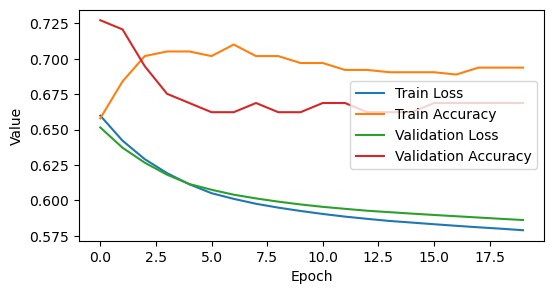

In [62]:
# Train the baseline model with imbalanced data
model, base_metrics_res, _, _ = do_all(X_train_big, y_train_big, X_test, y_test)
del model

# Optimized the model

## Balanced the data

In [63]:
def balance_data(X, y):
    # Check for balance
    unique, counts = torch.unique(y, return_counts=True)
    res_dict = dict(zip(unique.tolist(), counts.tolist()))
    print(f"Original Class distribution: {res_dict}")

    # Resample for imbalance
    if res_dict[0]/res_dict[1] > 6/4:
        print(f"Imbalanced data")
        # Balanced the data
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X, y)
        
        # Convert to PyTorch tensors
        X_resampled_tensor = torch.tensor(X_resampled, dtype=torch.float32)
        y_resampled_tensor = torch.tensor(y_resampled, dtype=torch.float32)
        
        # Check the balance after resample
        unique, counts = torch.unique(y_resampled_tensor, return_counts=True)
        res2 = dict(zip(unique.tolist(), counts.tolist()))
        print(f"Class distribution after SMOTE: {res2}")
        
        if res2[0]/res2[1] > 6/4:
            print(f"Balanced data")
            
    return X_resampled_tensor, y_resampled_tensor

To train the baseline model, we only balanced the training set. 

In [64]:
X_train, y_train = balance_data(X_train_nb, y_train_nb)

Original Class distribution: {0: 300, 1: 160}
Imbalanced data
Class distribution after SMOTE: {0.0: 300, 1.0: 300}


    epoch  train_loss  train_accuracy  train_recall  train_precision  \
11     12    0.664142            0.61      0.473333         0.651376   

    train_F2  val_loss  val_accuracy  val_recall  val_precision   val_F2   
11  0.500705  0.633287      0.733766    0.666667       0.610169  0.654545  


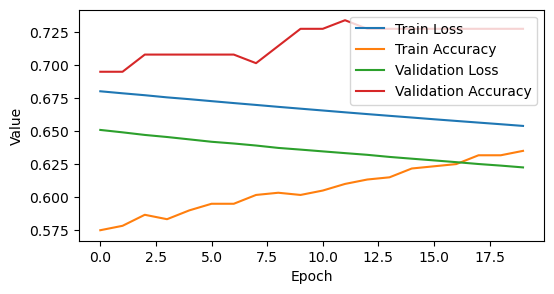

In [65]:
# Train the model
model, base_metrics_res, _, _ = do_all(X_train, y_train, X_val_nb, y_val_nb)

In [66]:
# Define a function to display the optimized results
def display_opt_res(output, entities="", subtitle=""):
    # Extract names, accuracies, and losses
    names = list(output.keys())
    accuracies = [values[0] for values in output.values()]
    losses = [values[1] for values in output.values()]
    
    # Set up the bar plot
    x = range(len(names))  # The x positions for the bars
    
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Plot accuracy
    ax.bar(x, accuracies, width=0.4, label='F2', align='center')
    
    # Plot loss (use a different color and position it next to accuracy bars)
    ax.bar([p + 0.4 for p in x], losses, width=0.4, label='Loss', align='center')

    # Annotate bars with values
    for i in range(len(names)):
        # Accuracy annotation
        ax.text(i, accuracies[i], f'{accuracies[i]:.4f}', ha='center', va='bottom')
        # Loss annotation
        ax.text(i + 0.4, losses[i], f'{losses[i]:.4f}', ha='center', va='bottom')
    
    # Labeling
    ax.set_xlabel(entities)
    ax.set_ylabel("Value")
    ax.set_title(f'Validation Accuracy and Loss for {entities} {subtitle}')
    ax.set_xticks([p + 0.2 for p in x])
    ax.set_xticklabels(names)
    ax.legend()

    # Display the plot
    plt.tight_layout()
    plt.show()

    # Get the optimized optimizer
    res_opt = sorted(output.items(), key=lambda x: (-x[1][0], x[1][1]))
    print(res_opt)

    return res_opt[0][0]

## Optimize the learning rate and the batch size

   epoch  train_loss  train_accuracy  train_recall  train_precision  train_F2  \
0      1    0.591378            0.69      0.663333         0.700704  0.670485   

   val_loss  val_accuracy  val_recall  val_precision   val_F2   
0  0.661766      0.636364    0.962963       0.490566  0.807453  


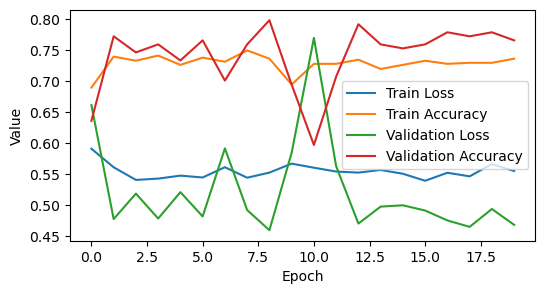

   epoch  train_loss  train_accuracy  train_recall  train_precision  train_F2  \
0      1    0.627935            0.67          0.62         0.688889  0.632653   

   val_loss  val_accuracy  val_recall  val_precision   val_F2   
0  0.581267      0.733766    0.907407       0.576471  0.813953  


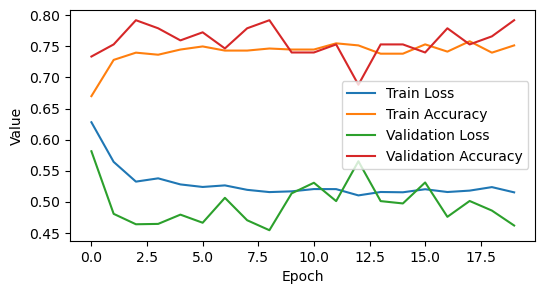

   epoch  train_loss  train_accuracy  train_recall  train_precision  train_F2  \
0      1    0.643563           0.645          0.56         0.674699   0.57971   

   val_loss  val_accuracy  val_recall  val_precision   val_F2   
0  0.617265      0.694805    0.962963       0.536082  0.830671  


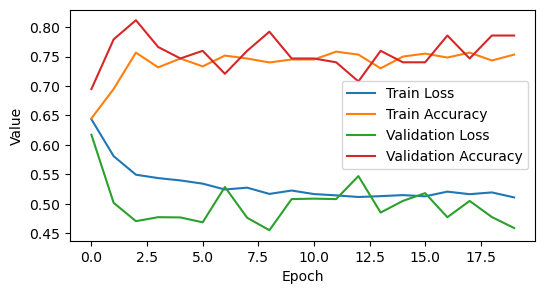

   epoch  train_loss  train_accuracy  train_recall  train_precision  train_F2  \
6      7     0.53872        0.731667      0.693333         0.750903   0.70413   

   val_loss  val_accuracy  val_recall  val_precision   val_F2   
6  0.513571      0.746753    0.814815        0.60274  0.761246  


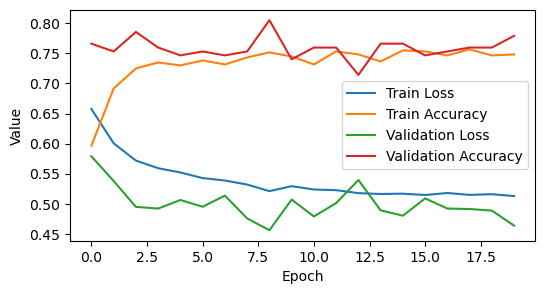

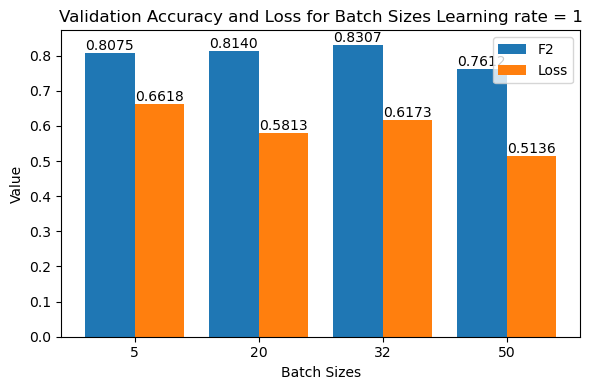

[(32, [0.8306709265175718, 0.6172648172873956]), (20, [0.813953488372093, 0.5812665897530395]), (5, [0.8074534161490683, 0.6617659605168676]), (50, [0.7612456747404842, 0.513571196562284])]
   epoch  train_loss  train_accuracy  train_recall  train_precision  train_F2  \
6      7    0.532423        0.746667      0.703333         0.770073  0.715739   

   val_loss  val_accuracy  val_recall  val_precision   val_F2   
6  0.506072      0.753247    0.796296       0.614286  0.751748  


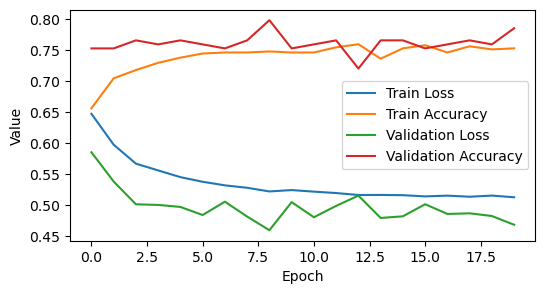

   epoch  train_loss  train_accuracy  train_recall  train_precision  train_F2  \
3      4    0.620614            0.69      0.593333         0.735537  0.617198   

   val_loss  val_accuracy  val_recall  val_precision   val_F2   
3  0.578097      0.746753    0.740741       0.615385  0.711744  


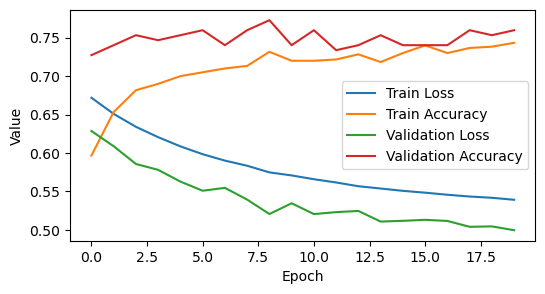

   epoch  train_loss  train_accuracy  train_recall  train_precision  train_F2  \
6      7    0.612331        0.678333      0.556667         0.735683  0.585144   

   val_loss  val_accuracy  val_recall  val_precision   val_F2   
6  0.577074       0.75974    0.777778       0.626866  0.742049  


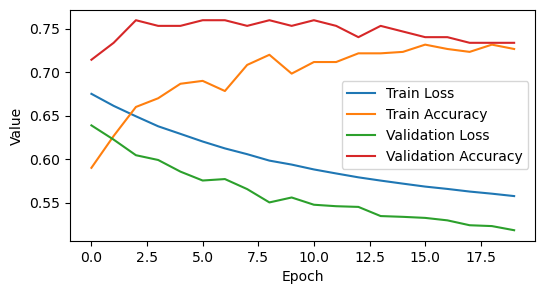

    epoch  train_loss  train_accuracy  train_recall  train_precision  \
11     12    0.606498        0.703333      0.613333         0.747967   

    train_F2  val_loss  val_accuracy  val_recall  val_precision   val_F2   
11  0.636238  0.568405       0.75974    0.759259       0.630769  0.729537  


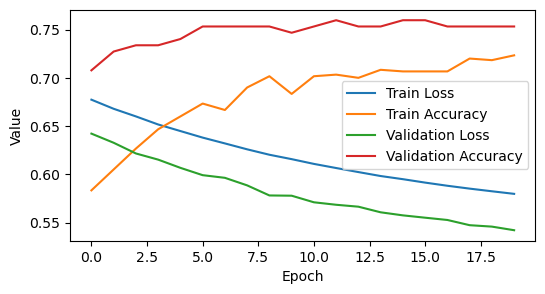

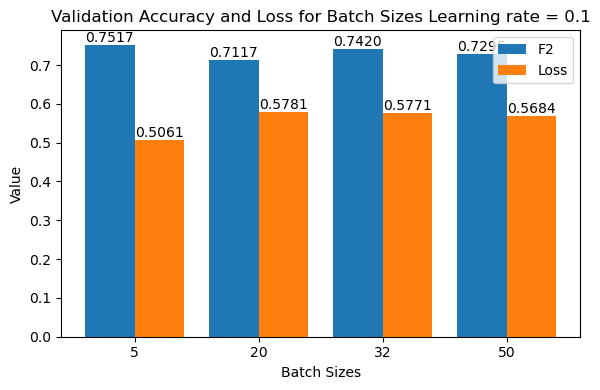

[(5, [0.7517482517482518, 0.5060722327658108]), (32, [0.7420494699646644, 0.577073576388421]), (50, [0.7295373665480427, 0.5684049323007658]), (20, [0.7117437722419929, 0.5780966235445691])]
    epoch  train_loss  train_accuracy  train_recall  train_precision  \
11     12     0.60631        0.703333      0.613333         0.747967   

    train_F2  val_loss  val_accuracy  val_recall  val_precision   val_F2   
11  0.636238   0.56847       0.75974    0.759259       0.630769  0.729537  


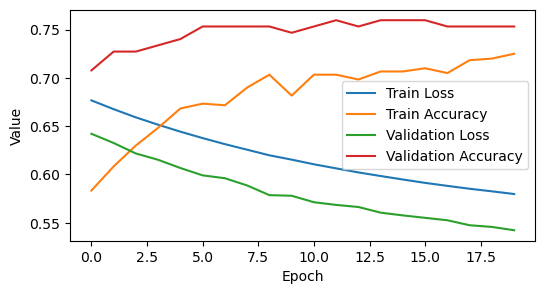

    epoch  train_loss  train_accuracy  train_recall  train_precision  \
13     14    0.651734           0.645      0.523333          0.69163   

    train_F2  val_loss  val_accuracy  val_recall  val_precision   val_F2   
13  0.550105  0.619356      0.746753    0.703704       0.622951  0.685921  


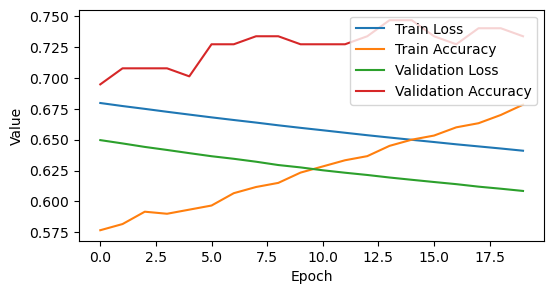

    epoch  train_loss  train_accuracy  train_recall  train_precision  \
11     12    0.664142            0.61      0.473333         0.651376   

    train_F2  val_loss  val_accuracy  val_recall  val_precision   val_F2   
11  0.500705  0.633287      0.733766    0.666667       0.610169  0.654545  


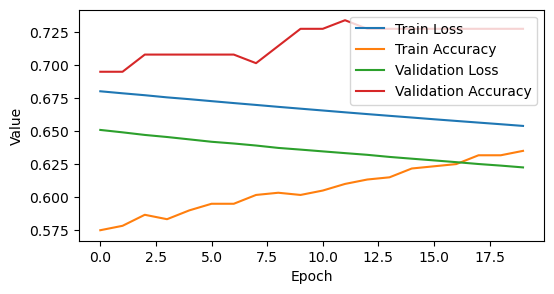

    epoch  train_loss  train_accuracy  train_recall  train_precision  \
18     19    0.663862        0.611667          0.47         0.655814   

    train_F2  val_loss  val_accuracy  val_recall  val_precision   val_F2   
18  0.498233   0.63323      0.733766    0.666667       0.610169  0.654545  


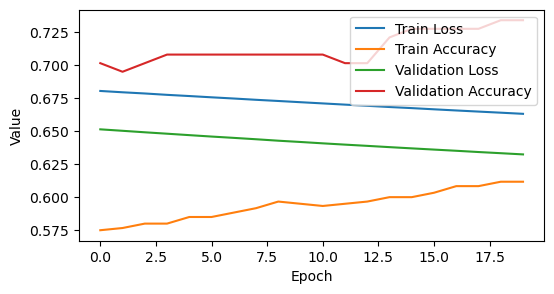

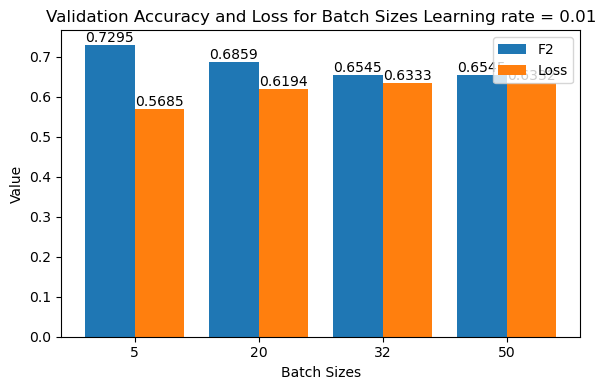

[(5, [0.7295373665480427, 0.5684695034832149]), (20, [0.6859205776173286, 0.6193558945284261]), (50, [0.6545454545454545, 0.6332297642509659]), (32, [0.6545454545454545, 0.6332871155305342])]
    epoch  train_loss  train_accuracy  train_recall  train_precision  \
18     19    0.663834        0.611667          0.47         0.655814   

    train_F2  val_loss  val_accuracy  val_recall  val_precision   val_F2   
18  0.498233  0.633233      0.733766    0.666667       0.610169  0.654545  


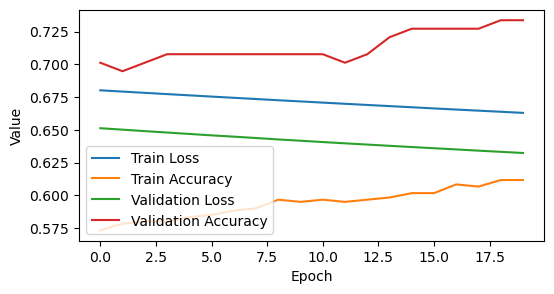

   epoch  train_loss  train_accuracy  train_recall  train_precision  train_F2  \
0      1    0.680532        0.571667          0.41         0.605911  0.438346   

   val_loss  val_accuracy  val_recall  val_precision   val_F2   
0  0.652102      0.707792     0.62963       0.576271  0.618182  


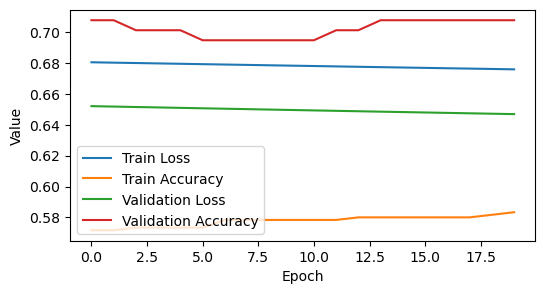

   epoch  train_loss  train_accuracy  train_recall  train_precision  train_F2  \
0      1    0.680567        0.571667          0.41         0.605911  0.438346   

   val_loss  val_accuracy  val_recall  val_precision   val_F2   
0  0.652224      0.707792     0.62963       0.576271  0.618182  


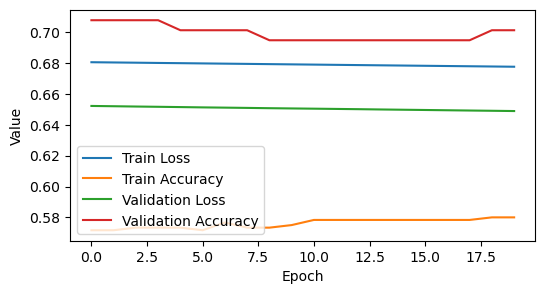

   epoch  train_loss  train_accuracy  train_recall  train_precision  train_F2  \
0      1    0.680591        0.571667          0.41         0.605911  0.438346   

   val_loss  val_accuracy  val_recall  val_precision   val_F2   
0  0.652271      0.707792     0.62963       0.576271  0.618182  


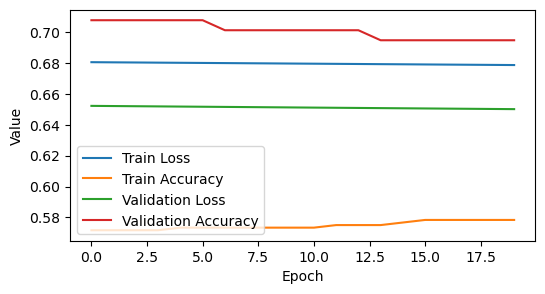

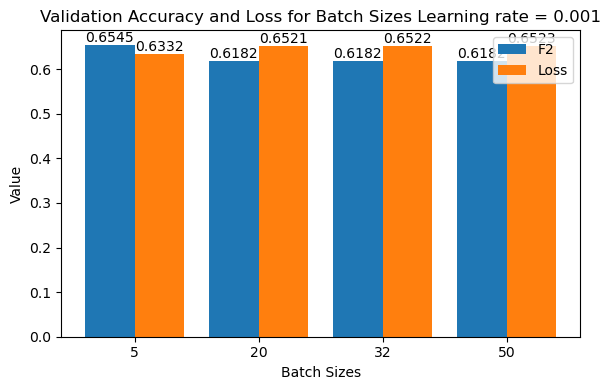

[(5, [0.6545454545454545, 0.633232541285552]), (20, [0.6181818181818183, 0.6521024851055889]), (32, [0.6181818181818183, 0.6522240561324281]), (50, [0.6181818181818183, 0.6522710354297192])]


In [67]:
batch_sizes = [5, 20, 32, 50]
lrs = [1, 0.1, 0.01, 0.001]
output_bs = dict()

for lr in lrs:
    for bs in batch_sizes:
        model, res, f2, loss = do_all(X_train, y_train, X_val_nb, y_val_nb, learning_rate=lr, batch_size=bs)
        output_bs[bs] = [f2, loss]
    lr_fig = display_opt_res(output_bs, f"Batch Sizes", subtitle=f"Learning rate = {lr}")

## Optimize the optimizer

   epoch  train_loss  train_accuracy  train_recall  train_precision  train_F2  \
6      7     0.53872        0.731667      0.693333         0.750903   0.70413   

   val_loss  val_accuracy  val_recall  val_precision   val_F2   
6  0.513571      0.746753    0.814815        0.60274  0.761246  


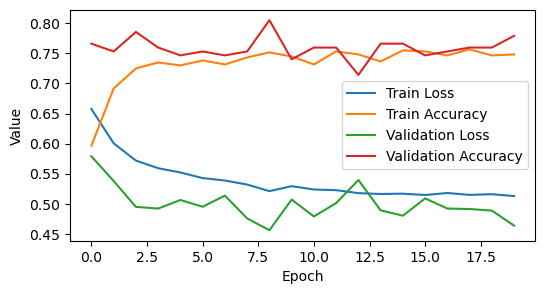

    epoch  train_loss  train_accuracy  train_recall  train_precision  \
12     13    0.561066        0.728333          0.76         0.714734   

    train_F2  val_loss  val_accuracy  val_recall  val_precision   val_F2   
12  0.750494  0.626467      0.694805    0.925926       0.537634  0.809061  


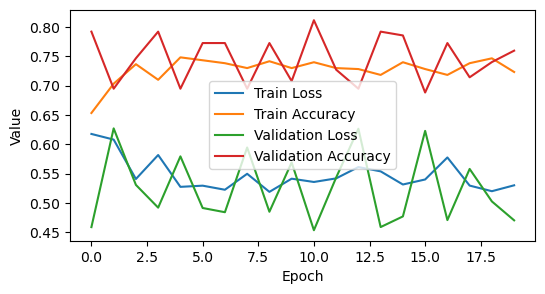

   epoch  train_loss  train_accuracy  train_recall  train_precision  train_F2  \
3      4    1.693932        0.648333      0.646667         0.648829  0.647098   

   val_loss  val_accuracy  val_recall  val_precision   val_F2   
3  2.259875      0.616883    0.944444       0.476636  0.789474  


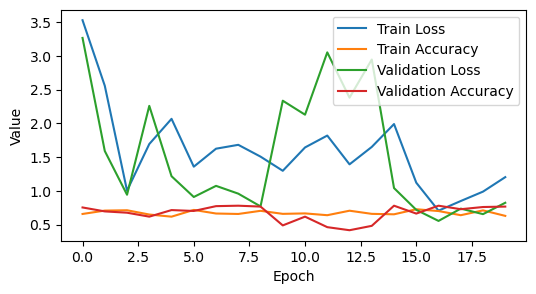

    epoch  train_loss  train_accuracy  train_recall  train_precision  \
17     18    1.041291            0.69      0.663333         0.700704   

    train_F2  val_loss  val_accuracy  val_recall  val_precision   val_F2   
17  0.670485  0.781285      0.668831    0.944444       0.515152  0.809524  


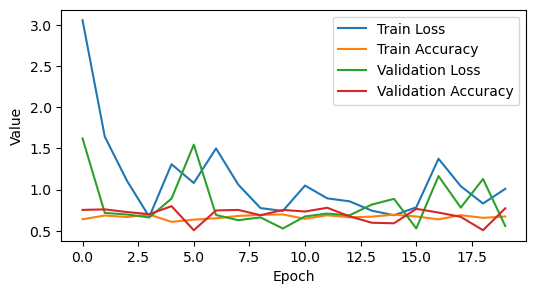

    epoch  train_loss  train_accuracy  train_recall  train_precision  \
16     17    6.013473        0.716667      0.713333         0.718121   

    train_F2  val_loss  val_accuracy  val_recall  val_precision   val_F2   
16  0.714286  5.277944      0.623377    0.944444       0.481132  0.791925  


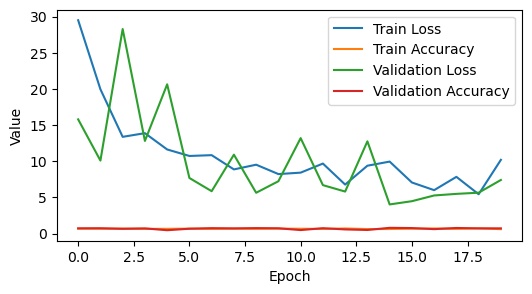

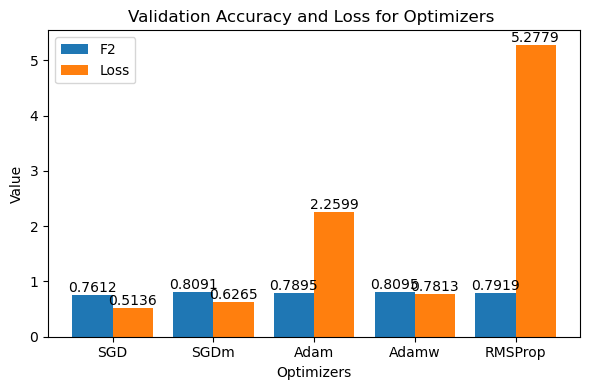

[('Adamw', [0.8095238095238094, 0.7812850142454172]), ('SGDm', [0.8090614886731391, 0.6264666164076174]), ('RMSProp', [0.7919254658385091, 5.277943830985527]), ('Adam', [0.7894736842105263, 2.25987514790583]), ('SGD', [0.7612456747404842, 0.513571196562284])]
Adamw


In [68]:
opt_lr = 1
opt_bs = 50
optimizers = ["SGD", "SGDm","Adam", "Adamw", "RMSProp"]
output_opt = dict()

for name in optimizers:
    model, res, f2, loss = do_all(X_train, y_train, X_val_nb, y_val_nb, optimizer_name = name, learning_rate=opt_lr, batch_size=opt_bs)
    output_opt[name] = [f2, loss]

opt_optimizer_name = display_opt_res(output_opt, "Optimizers")
print(opt_optimizer_name)

## Optimize the learning rate

   epoch  train_loss  train_accuracy  train_recall  train_precision  train_F2  \
6      7     0.53872        0.731667      0.693333         0.750903   0.70413   

   val_loss  val_accuracy  val_recall  val_precision   val_F2   
6  0.513571      0.746753    0.814815        0.60274  0.761246  


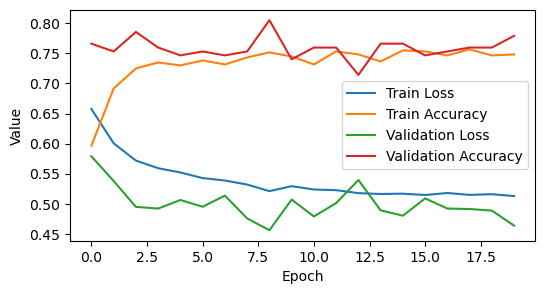

    epoch  train_loss  train_accuracy  train_recall  train_precision  \
11     12    0.606498        0.703333      0.613333         0.747967   

    train_F2  val_loss  val_accuracy  val_recall  val_precision   val_F2   
11  0.636238  0.568405       0.75974    0.759259       0.630769  0.729537  


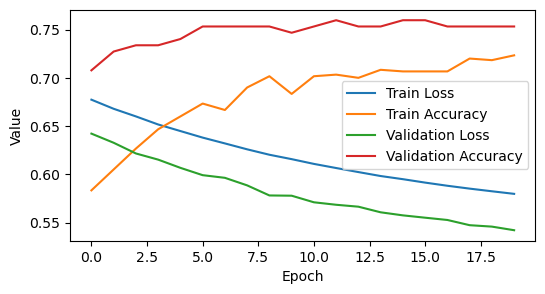

    epoch  train_loss  train_accuracy  train_recall  train_precision  \
18     19    0.663862        0.611667          0.47         0.655814   

    train_F2  val_loss  val_accuracy  val_recall  val_precision   val_F2   
18  0.498233   0.63323      0.733766    0.666667       0.610169  0.654545  


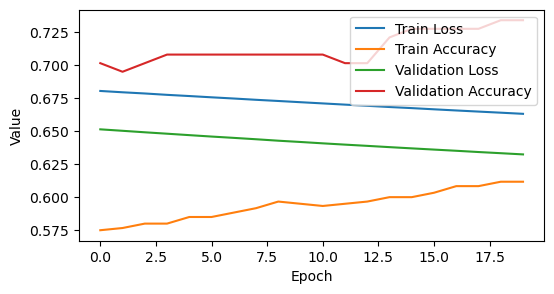

   epoch  train_loss  train_accuracy  train_recall  train_precision  train_F2  \
0      1    0.680591        0.571667          0.41         0.605911  0.438346   

   val_loss  val_accuracy  val_recall  val_precision   val_F2   
0  0.652271      0.707792     0.62963       0.576271  0.618182  


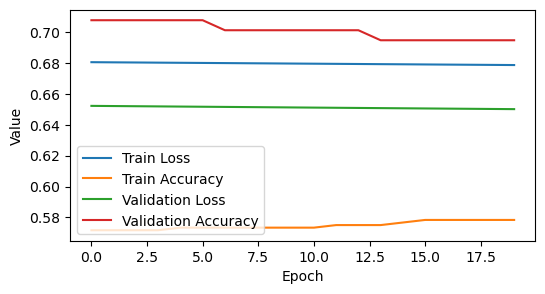

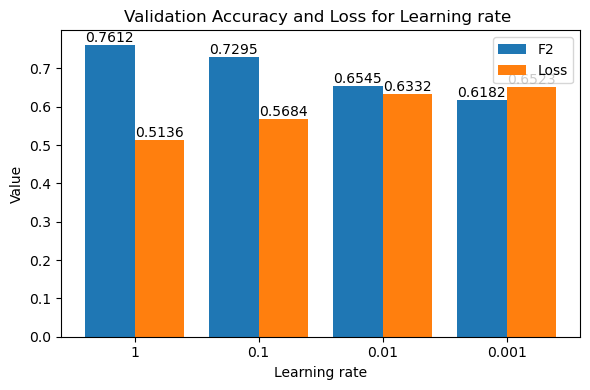

[(1, [0.7612456747404842, 0.513571196562284]), (0.1, [0.7295373665480427, 0.5684049323007658]), (0.01, [0.6545454545454545, 0.6332297642509659]), (0.001, [0.6181818181818183, 0.6522710354297192])]
1


In [69]:
lrs2 = [1, 0.1, 0.01, 0.001]
output_lr = dict()

for lr2 in lrs2:
    model, res, f2, loss = do_all(X_train, y_train, X_val_nb, y_val_nb, learning_rate=lr2, batch_size=opt_bs)
    output_lr[lr2] = [f2, loss]
opt_lr = display_opt_res(output_lr, f"Learning rate")
print(opt_lr)

## Optimized the number of epochs

    epoch  train_loss  train_accuracy  train_recall  train_precision  \
17     18    1.041291            0.69      0.663333         0.700704   

    train_F2  val_loss  val_accuracy  val_recall  val_precision   val_F2   
17  0.670485  0.781285      0.668831    0.944444       0.515152  0.809524  


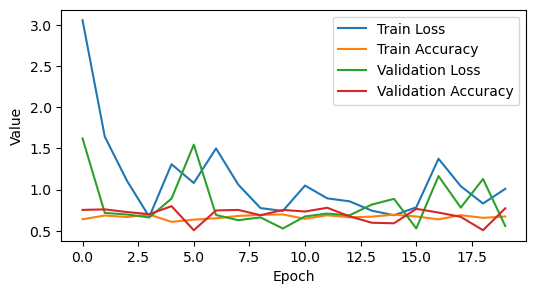

    epoch  train_loss  train_accuracy  train_recall  train_precision  \
17     18    1.041291            0.69      0.663333         0.700704   

    train_F2  val_loss  val_accuracy  val_recall  val_precision   val_F2   
17  0.670485  0.781285      0.668831    0.944444       0.515152  0.809524  


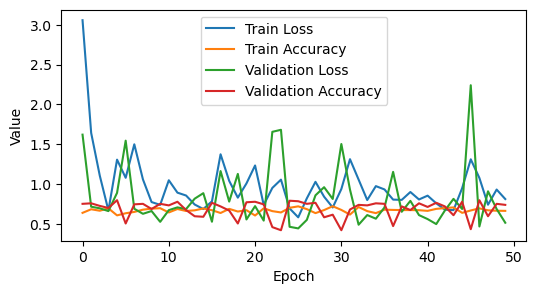

    epoch  train_loss  train_accuracy  train_recall  train_precision  \
40     41    0.947499           0.645          0.66         0.640777   

    train_F2  val_loss  val_accuracy  val_recall  val_precision  val_F2   
40  0.656064  1.407676      0.577922         1.0       0.453782  0.80597  


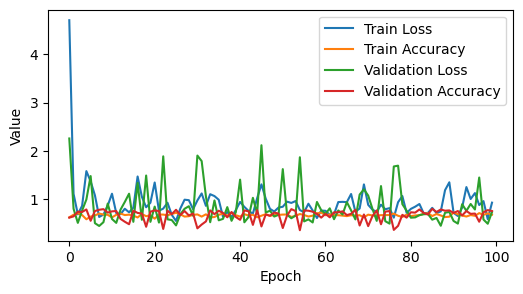

    epoch  train_loss  train_accuracy  train_recall  train_precision  \
29     30    0.822316        0.658333          0.68         0.651757   

    train_F2  val_loss  val_accuracy  val_recall  val_precision   val_F2   
29  0.674157  1.034429      0.636364    0.981481       0.490741  0.817901  


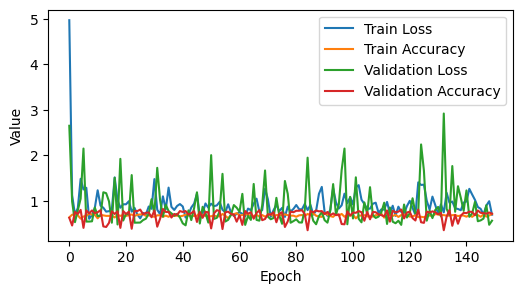

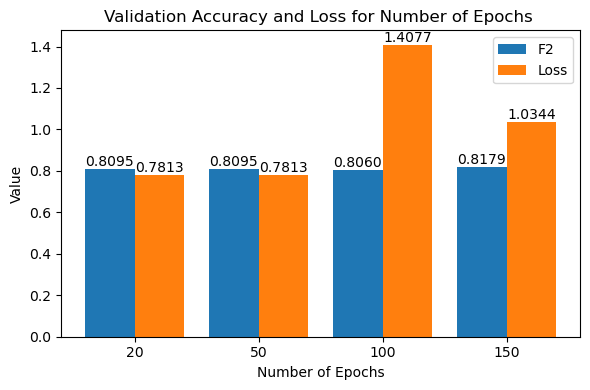

[(150, [0.8179012345679012, 1.034428562436785]), (20, [0.8095238095238094, 0.7812850142454172]), (50, [0.8095238095238094, 0.7812850142454172]), (100, [0.8059701492537313, 1.4076759706843982])]
150


In [70]:
epochs = [20, 50, 100, 150]
output_epoch = dict()

for epoch in epochs:
    model, res, f2, loss = do_all(X_train, y_train, X_val_nb, y_val_nb, opt_optimizer_name, learning_rate = opt_lr, batch_size = opt_bs, epochs = epoch)
    output_epoch[epoch] = [f2, loss]

opt_epochs = display_opt_res(output_epoch, "Number of Epochs")
print(opt_epochs)

# Retrian the best model with training and validation set and get the test results

Original Class distribution: {0: 400, 1: 214}
Imbalanced data
Class distribution after SMOTE: {0.0: 400, 1.0: 400}
    epoch  train_loss  train_accuracy  train_recall  train_precision  \
87     88     0.75038         0.68125          0.68         0.681704   

    train_F2  val_loss  val_accuracy  val_recall  val_precision   val_F2   
87   0.68034  1.050782      0.655844    0.981481       0.504762  0.825545  


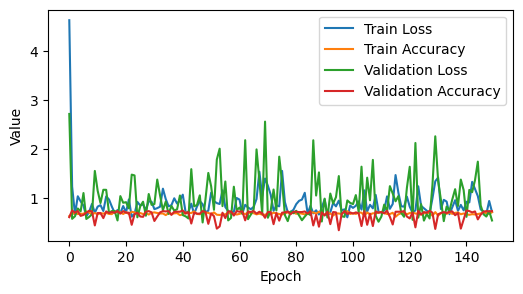

In [71]:
# Balance the big training set
X_train_big_balanced, y_train_big_balanced = balance_data(X_train_big, y_train_big)

# Retrain and test the best model
best_model, best_res, best_f2, best_loss = do_all(X_train_big_balanced, y_train_big_balanced, X_test, y_test, 
                                    opt_optimizer_name, learning_rate = opt_lr, batch_size = opt_bs, epochs = opt_epochs)